# Проект - Телеком: прогноз оттока клиентов

## Описание проекта

Отдел маркетинга провел исследование и выяснил, что в последнее время из нашей компании все чаще начали уходить клиенты к конкурентам.
Стоимость маркетинговых затрат на возврат ушедшего клиента весьма высока, дешевле удержать клиента. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Цель: в течении 7 дней разработать модель прогнозирования оттока клиентов точностью AUC-ROC не менее 0.85.

План работ:

- Предванительный анализ

- Предобработка

- Исседовательский анализ

- Подготовка признаков: 

- Обучение модели

- Проверка модели

- Отчет

## Предварительный анализ

In [1]:
pip install phik

     |████████████████████████████████| 679 kB 970 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

     |████████████████████████████████| 572 kB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score, confusion_matrix, roc_curve, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder

import phik
from phik.report import plot_correlation_matrix

import shap

In [5]:
print('Информация о договоре')
display(contract.head())
contract.info()

Информация о договоре


customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


EndDate - целевой признак: если в столбце даты нет, то клиент не отказался от услуг (0), иначе (1)

In [6]:
print('Персональные данные клиента')
display(personal.head())
personal.info()

Персональные данные клиента


customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
print('Информация об интернет-услугах')
display(internet.head())
internet.info()

Информация об интернет-услугах


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [8]:
print('Информация об услугах телефонии')
display(phone.head())
phone.info()

Информация об услугах телефонии


customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков нет. Количество строк в информации об услугах интернета и телефонии меньше, чем общее количество клиентов. Это связано с тем, что не все клиенты пользуются обеими услугами.

## Предобработка

In [9]:
# Сборка единой таблицы по customerID
class merger():
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        data = pd.DataFrame(X).merge(contract, on='customerID', how='left', copy=False)
        data = data.merge(personal, on='customerID', how='left', copy=False)
        data = data.merge(internet, on='customerID', how='left', copy=False)
        data = data.merge(phone, on='customerID', how='left', copy=False)
        return data

In [10]:
# Добавление признаков Phone и Internet - об использовании пользователем сервисов
class service_qualifier():
    def fit(self,X, y=None):
        return self

    def transform(self, X):
        data= X
        data['Phone'] = np.where(data['MultipleLines'].isna(), 0, 1)
        data['Internet'] = np.where(data['InternetService'].isna(), 0, 1)
        data[['Phone','Internet']] = data[['Phone','Internet']].astype('bool')
        return data

In [11]:
#преобразование типов данных
class types_fix:
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        data = X
        
        data = data.set_index('customerID')
        
        # преобразование столбца даты в соответствующий тип данных
        data['BeginDate'] = pd.to_datetime(
        data['BeginDate'], format='%Y.%m.%d')
        
        #приведение столбцов к типу bool
        bool_category = ['PaperlessBilling','Partner','Dependents','OnlineSecurity','OnlineBackup',
                         'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
        data[bool_category] = data[bool_category].fillna(0)
        data[bool_category] = data[bool_category].replace('No',0)
        data[bool_category] = data[bool_category].replace('Yes',1)
        data[bool_category] = data[bool_category].astype('bool')
        data['gender'] = data['gender'].replace('Female',0)
        data['gender'] = data['gender'].replace('Male',1)
        data['gender'] = data['gender'].astype('bool')
        data = data.rename(
            columns={'PaperlessBilling':'IsPaperlessBilling','gender':'IsMale',
                     'Partner':'HavePartner','Dependents':'HaveDependents'})
        
        # заполнение пустых значений 'TotalCharges' нулями, приведение к типу float
        data['TotalCharges'] = data['TotalCharges'].replace(r'^\s*$', 0, regex=True)
        data['TotalCharges'] = data['TotalCharges'].astype(float)
        
        # замена типа даннхы о наличии пенсионного статуса
        data['SeniorCitizen'] = data['SeniorCitizen'].astype('bool')
        data = data.rename(
            columns={'SeniorCitizen':'IsSeniorCitizen'})
        
        # заполнение пропусков, приведение к категориальному типу
        category = ['Type','PaymentMethod','InternetService','MultipleLines']
        data[category] = data[category].fillna('Not Used')
        data[category] = data[category].astype('category')
        
        return data

In [12]:
# замена даты начала пользования услугами на кол-во дней с начала до 1 февраля 2020
class date_diff():
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        y = X['EndDate'].replace('No','2020-02-01')
        y = pd.to_datetime(y, format='%Y.%m.%d')
        X['BeginDate'] = (y - X['BeginDate'])/np.timedelta64(1,'D')
        X = X.rename(
                columns = {'BeginDate':'DaysFromBegin'})
        X['DaysFromBegin'] = X['DaysFromBegin'].astype('int')
        return X

In [13]:
# Обработка целевого признака, 0 - клиент не ушел
class targeter():
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        data = X
        data['EndDate'] = np.where(data['EndDate']=='No',0,1)
        data['EndDate'] = data['EndDate'].astype('bool')
        data = data.rename(
            columns={'EndDate':'IsLeft'})
        return data

In [14]:
pipe = Pipeline([
    ('Merge', merger()),
    ('Service qualifier', service_qualifier()),
    ('Types fix', types_fix()),
    ('Date from begin', date_diff()),
    ('Targeter', targeter())
])

In [15]:
data = pipe.fit_transform(contract['customerID'])

In [16]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [17]:
contract.shape[0]

7043

In [18]:
# customerID повторяется 4 раза, поэтому -4, +2 столбца добавили
contract.shape[1]+personal.shape[1]+internet.shape[1]+phone.shape[1] -4 +2

21

In [19]:
data.shape

(7043, 21)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   DaysFromBegin       7043 non-null   int64   
 1   IsLeft              7043 non-null   bool    
 2   Type                7043 non-null   category
 3   IsPaperlessBilling  7043 non-null   bool    
 4   PaymentMethod       7043 non-null   category
 5   MonthlyCharges      7043 non-null   float64 
 6   TotalCharges        7043 non-null   float64 
 7   IsMale              7043 non-null   bool    
 8   IsSeniorCitizen     7043 non-null   bool    
 9   HavePartner         7043 non-null   bool    
 10  HaveDependents      7043 non-null   bool    
 11  InternetService     7043 non-null   category
 12  OnlineSecurity      7043 non-null   bool    
 13  OnlineBackup        7043 non-null   bool    
 14  DeviceProtection    7043 non-null   bool    
 15  TechSupport         7043 non

In [21]:
data.head(20)

DaysFromBegin  IsLeft            Type  IsPaperlessBilling  \
customerID                                                              
7590-VHVEG             31   False  Month-to-month                True   
5575-GNVDE           1036   False        One year               False   
3668-QPYBK            123   False  Month-to-month                True   
7795-CFOCW           1371   False        One year               False   
9237-HQITU            153   False  Month-to-month                True   
9305-CDSKC            337   False  Month-to-month                True   
1452-KIOVK            671   False  Month-to-month                True   
6713-OKOMC            306   False  Month-to-month               False   
7892-POOKP            945   False  Month-to-month                True   
6388-TABGU            882    True        One year               False   
9763-GRSKD            396   False  Month-to-month                True   
7469-LKBCI            488   False        Two year               False   
8091-TTVAX           1767   False        One year               False   
0280-XJGEX           1614   False  Month-to-month                True   
5129-JLPIS            761   False  Month-to-month                True   
3655-SNQYZ            670    True        Two year               False   
8191-XWSZG           1584   False        One year               False   
9959-WOFKT           2163   False        Two year               False   
4190-MFLUW            396   False  Month-to-month               False   
4183-MYFRB            641   False  Month-to-month                True   

                        PaymentMethod  MonthlyCharges  TotalCharges  IsMale  \
customerID                                                                    
7590-VHVEG           Electronic check           29.85         31.04   False   
5575-GNVDE               Mailed check           56.95       2071.84    True   
3668-QPYBK               Mailed check           53.85        226.17    True   
7795-CFOCW  Bank transfer (automatic)           42.30       1960.60    True   
9237-HQITU           Electronic check           70.70        353.50   False   
9305-CDSKC           Electronic check           99.65       1150.96   False   
1452-KIOVK    Credit card (automatic)           89.10       2058.21    True   
6713-OKOMC               Mailed check           29.75        300.48   False   
7892-POOKP           Electronic check          104.80       3573.68   False   
6388-TABGU  Bank transfer (automatic)           56.15       1628.35    True   
9763-GRSKD               Mailed check           49.95        649.35    True   
7469-LKBCI    Credit card (automatic)           18.95        312.30    True   
8091-TTVAX    Credit card (automatic)          100.35       6111.31    True   
0280-XJGEX  Bank transfer (automatic)          103.70       5496.10    True   
5129-JLPIS           Electronic check          105.50       2637.50    True   
3655-SNQYZ    Credit card (automatic)          113.25       2491.50   False   
8191-XWSZG               Mailed check           20.65       1106.01   False   
9959-WOFKT  Bank transfer (automatic)          106.70       8257.51    True   
4190-MFLUW    Credit card (automatic)           55.20        789.36   False   
4183-MYFRB           Electronic check           90.05       1891.05   False   

            IsSeniorCitizen  HavePartner  ...  InternetService OnlineSecurity  \
customerID                                ...                                   
7590-VHVEG            False         True  ...              DSL          False   
5575-GNVDE            False        False  ...              DSL           True   
3668-QPYBK            False        False  ...              DSL           True   
7795-CFOCW            False        False  ...              DSL           True   
9237-HQITU            False        False  ...      Fiber optic          False   
9305-CDSKC            False        False  ...      Fiber optic          False   
1452-KIOVK        

Данные объединены в одну таблицу.

Добавлены данные об использовании интернета и телефонии, о количестве дней с начала пользования услугами.

Данные преобразованы и приведены к соответствующим типам, заполнены пропуски.

## Исследовательский анализ

Цель анализа - составление портрета уходящего клиента

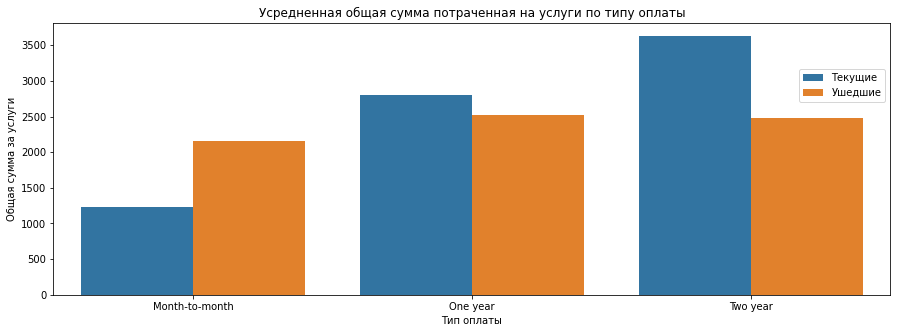

In [22]:
plt.figure(figsize=(15,5))
sns.barplot(data=data, x='Type', y='TotalCharges', hue='IsLeft', ci=None, estimator=np.mean)
plt.legend(['Текущие','Ушедшие'],bbox_to_anchor=(1, 0.85))
plt.title('Усредненная общая сумма потраченная на услуги по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Общая сумма за услуги');

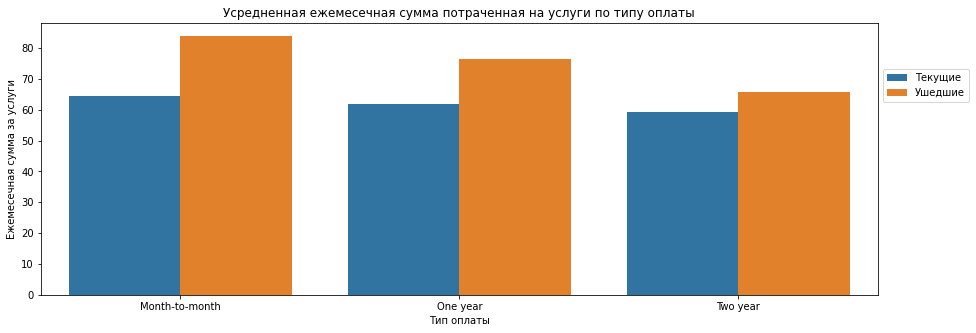

In [23]:
plt.figure(figsize=(15,5))
sns.barplot(data=data, x='Type', y='MonthlyCharges', hue='IsLeft', ci=None, estimator=np.mean)
plt.legend(['Текущие','Ушедшие'],bbox_to_anchor=(1, 0.85))
plt.title('Усредненная ежемесечная сумма потраченная на услуги по типу оплаты')
plt.xlabel('Тип оплаты')
plt.ylabel('Ежемесечная сумма за услуги');

Средняя сумма услуг за месяц, при любом виде оплаты, у действующих клиентов ниже, чем у тех, кто от услуг отказался.

Но среди тех, кто предпочел оплату раз в год или раз в два года, общая сумма за услуги в среднем больше. Это может говорить о том, что чем дольше пользователь платит за услуги компании, не пользуясь ежемесечным типом оплаты, тем меньше вероятность ухода этого пользователя.

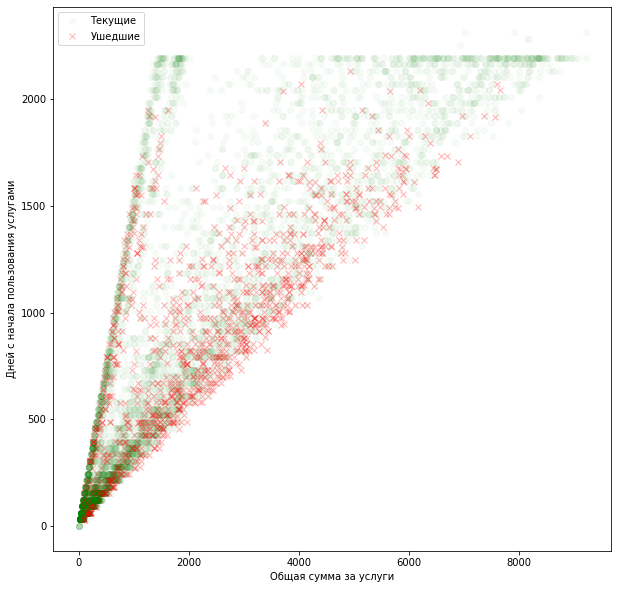

In [24]:
plt.figure(figsize=(10,10))
plt.xlabel('Общая сумма за услуги')
plt.ylabel('Дней с начала пользования услугами')
plt.plot(data[data['IsLeft']==False]['TotalCharges'], data[data['IsLeft']==False]['DaysFromBegin'],\
         'o', alpha=0.03,color='green')
plt.plot(data[data['IsLeft']==True]['TotalCharges'], data[data['IsLeft']==True]['DaysFromBegin'],\
         'x', alpha=0.3,color='red')
plt.legend(['Текущие','Ушедшие'])
plt.show();

Видно, что у компании много новых клиентов. Большая часть ушедших - клиенты, чьи расходы на услуги выше медианы, по пользователям с той же длительностью пользования услугами.

Среди тех, кто пользуется услугами дольше всего очень мало ушедших клиентов.

Также наблюдается группа текущих пользователей с минимальными возможными затратами, в которой есть и те кто отказывается от услуг.

In [25]:
# ушедшие клиенты/общее число клиентов
print('Процент ушедших клиентов:', 
     round(data[data['IsLeft']==True].shape[0]/data.shape[0],2))

# ушедшие клиенты/общее число клиентов для выбраных данных, разница True-False
for col in data.select_dtypes('bool').columns[1:]:
    a=data[(data['IsLeft']==True)&(data[col]==True)].shape[0]/data[data[col]==True].shape[0]
    b=data[(data['IsLeft']==True)&(data[col]==False)].shape[0]/data[data[col]==False].shape[0]
    print('Ушедшие клиенты: True, False, True-False: ', end='')
    print(round(a,2), round(b,2), round(a-b,2), 'столбец', col)

Процент ушедших клиентов: 0.16
Ушедшие клиенты: True, False, True-False: 0.17 0.13 0.04 столбец IsPaperlessBilling
Ушедшие клиенты: True, False, True-False: 0.16 0.15 0.01 столбец IsMale
Ушедшие клиенты: True, False, True-False: 0.2 0.15 0.06 столбец IsSeniorCitizen
Ушедшие клиенты: True, False, True-False: 0.21 0.1 0.11 столбец HavePartner
Ушедшие клиенты: True, False, True-False: 0.17 0.15 0.03 столбец HaveDependents
Ушедшие клиенты: True, False, True-False: 0.21 0.14 0.07 столбец OnlineSecurity
Ушедшие клиенты: True, False, True-False: 0.23 0.12 0.11 столбец OnlineBackup
Ушедшие клиенты: True, False, True-False: 0.23 0.12 0.11 столбец DeviceProtection
Ушедшие клиенты: True, False, True-False: 0.19 0.14 0.05 столбец TechSupport
Ушедшие клиенты: True, False, True-False: 0.22 0.12 0.1 столбец StreamingTV
Ушедшие клиенты: True, False, True-False: 0.22 0.11 0.11 столбец StreamingMovies
Ушедшие клиенты: True, False, True-False: 0.16 0.15 0.01 столбец Phone
Ушедшие клиенты: True, False, Tr

Клиенты с супругом откаываются от услуг значително чаще, чем клиенты без супруга.

Также чаще отказываются от услуг клиенты с пенсионным статусом и пользователи дополнительных интернет-услуг.

In [26]:
# ушедшие клиенты/общее число клиентов по методам оплаты
for method in data['PaymentMethod'].unique():
    print('Процент ушедших, среди использующих метод оплаты', method, ':', round(
        data[(data['IsLeft']==True)&(data['PaymentMethod']==method)].shape[0]/
        data[data['PaymentMethod']==method].shape[0],2))

Процент ушедших, среди использующих метод оплаты Electronic check : 0.15
Процент ушедших, среди использующих метод оплаты Mailed check : 0.07
Процент ушедших, среди использующих метод оплаты Bank transfer (automatic) : 0.21
Процент ушедших, среди использующих метод оплаты Credit card (automatic) : 0.21


In [27]:
for col in data.select_dtypes('category').columns:
    print(col)
    for category in data[col].unique():
        print('Процент ушедших, категория', category, ':', round(
            data[(data['IsLeft']==True)&(data[col]==category)].shape[0]/
            data[data[col]==category].shape[0],2))
    print()

Type
Процент ушедших, категория Month-to-month : 0.11
Процент ушедших, категория One year : 0.21
Процент ушедших, категория Two year : 0.22

PaymentMethod
Процент ушедших, категория Electronic check : 0.15
Процент ушедших, категория Mailed check : 0.07
Процент ушедших, категория Bank transfer (automatic) : 0.21
Процент ушедших, категория Credit card (automatic) : 0.21

InternetService
Процент ушедших, категория DSL : 0.14
Процент ушедших, категория Fiber optic : 0.19
Процент ушедших, категория Not Used : 0.1

MultipleLines
Процент ушедших, категория Not Used : 0.15
Процент ушедших, категория No : 0.09
Процент ушедших, категория Yes : 0.23



Type - При оплате раз в год и раз в два года клиенты уходят чаще, чем при помесячной оплате.

PaymentMethod - Процент ушедших клиентов, использующих автоматическую оплату, превышает средний процент ушедших клиентов (16%). А вот при использовании почтовых чеков, наоборот, уходит значительно меньше клиентов.

InternetService - Очень странно, что чаще уходят клиенты, использующие оптоволоконное соединение, ведь оно быстрее и надежнее DSL.

MultipleLines - наличие возможности ведения параллельных линий во время звонка плохо влияет на вероятность удержания клиента.

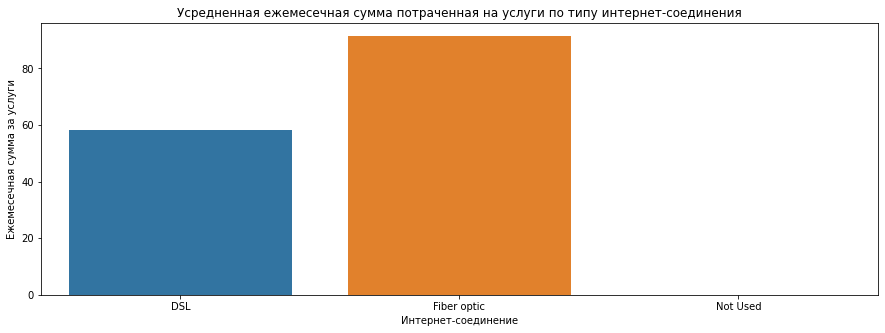

In [28]:
plt.figure(figsize=(15,5))
sns.barplot(data=data[data['Internet']==True], x='InternetService', y='MonthlyCharges', ci=None, estimator=np.mean)
plt.title('Усредненная ежемесечная сумма потраченная на услуги по типу интернет-соединения')
plt.xlabel('Интернет-соединение')
plt.ylabel('Ежемесечная сумма за услуги');

У пользователей оптоволоконного соединения среднемесячный чек на 57% дороже пользователей телефонной линии.

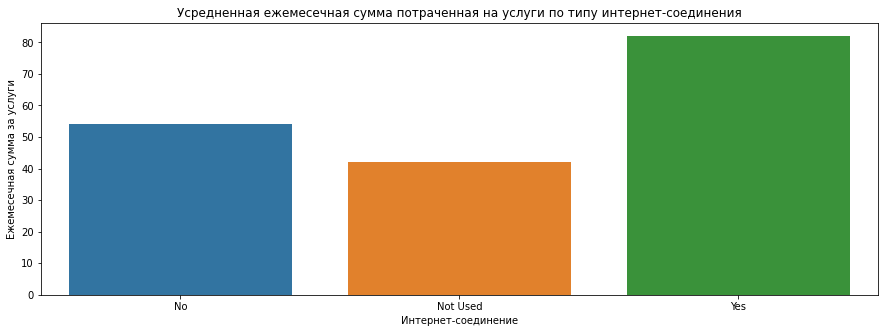

In [29]:
plt.figure(figsize=(15,5))
sns.barplot(data=data, x='MultipleLines', y='MonthlyCharges', ci=None, estimator=np.mean)
plt.title('Усредненная ежемесечная сумма потраченная на услуги по типу интернет-соединения')
plt.xlabel('Интернет-соединение')
plt.ylabel('Ежемесечная сумма за услуги');

При использовании MultipleLines месячные затраты возрастают на 51%

In [30]:
specific_client = data[((data['HavePartner']==True)|(data['IsSeniorCitizen']==True))&(
    (data['Type']=='One year')|(data['Type']=='Two year'))&(
    (data['PaymentMethod']=='Bank transfer (automatic)')|(data['PaymentMethod']=='Credit card (automatic)'))&(
    (data['InternetService']=='Fiber optic')|(data['MultipleLines']=='Yes'))]

In [31]:
print('Клиентов с супругом или имеющих пенсионный стутус, ')
print('пользующихся оптоволоконным соединением или MultipleLines,')
print('при автоматической оплате раз в год или раз в два года:',
      round(specific_client.shape[0],2))
print('Доля от всех клиентов:', round(specific_client.shape[0]/data.shape[0],2))
print('Процент ушедших, среди выбранной группы клиентов:', 
      round(specific_client[specific_client['IsLeft']==True].shape[0]/specific_client.shape[0],2))

Клиентов с супругом или имеющих пенсионный стутус, 
пользующихся оптоволоконным соединением или MultipleLines,
при автоматической оплате раз в год или раз в два года: 860
Доля от всех клиентов: 0.12
Процент ушедших, среди выбранной группы клиентов: 0.28


Процент ущедших в выбранной группе почти в два раза больше, чем во всем датасете

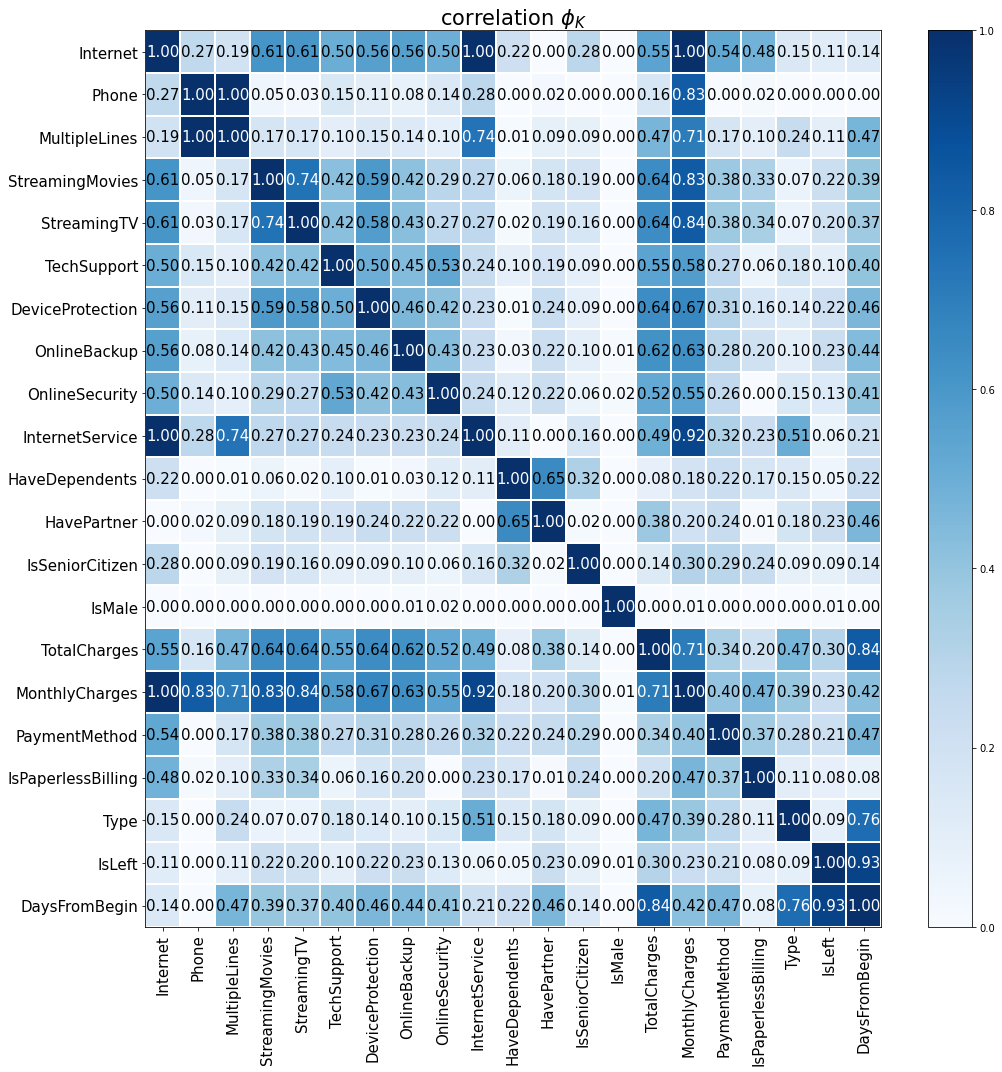

In [32]:
# Таблица корреляций
corr_table = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges'])
plot_correlation_matrix(corr_table.values, x_labels=corr_table.columns, y_labels=corr_table.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,15))

Отберем признаки, основываясь на графике корреляции.

In [33]:
class featurer():
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        data = X
        data = data.drop(['Internet','Phone', 'TechSupport', 'OnlineSecurity', 'HaveDependents', 'IsMale', 
                          'IsPaperlessBilling'], axis=1)
        try:
            data = data.drop(['EndDate'], axis=1)
        except:
            data = data.drop(['IsLeft'], axis=1)
            
        return data

In [34]:
contract.shape[0]

7043

In [35]:
targets = np.where(contract['EndDate']=='No',0,1)

train_id, test_id, train_target, test_target = train_test_split(
    contract['customerID'], targets, test_size=0.25, random_state=20623, stratify=targets)

In [36]:
train_id.shape

(5282,)

In [37]:
test_id.shape

(1761,)

In [38]:
features_prepare = Pipeline([
    ('Merge', merger()),
    ('Service qualifier', service_qualifier()),
    ('Types fix', types_fix()),
    ('Date from begin',date_diff()),
    ('Featurer', featurer())
])

In [39]:
train_features = features_prepare.fit_transform(train_id)
test_features = features_prepare.fit_transform(test_id)

In [40]:
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((5282, 13), (1761, 13), (5282,), (1761,))

In [41]:
train_features = pd.get_dummies(train_features, drop_first=True)
test_features = pd.get_dummies(test_features, drop_first=True)

## Обучение модели

### CatBoostClassifier

In [42]:
params = {'iterations': [500],
          'depth': [4, 5, 6],
          'learning_rate': [0.03, 0.1],
          'l2_leaf_reg': [1, 3, 5,]}

In [43]:
GS = GridSearchCV(estimator = CatBoostClassifier(random_state=20623),
                 param_grid = params,
                 scoring = ['roc_auc','accuracy'],
                 refit = 'roc_auc',
                 cv = 5)

In [44]:
GS.fit(train_features, train_target)

0:	learn: 0.6686026	total: 49ms	remaining: 24.5s
1:	learn: 0.6463083	total: 50.5ms	remaining: 12.6s
2:	learn: 0.6274771	total: 51.9ms	remaining: 8.59s
3:	learn: 0.6117688	total: 53.1ms	remaining: 6.59s
4:	learn: 0.5957895	total: 54.6ms	remaining: 5.4s
5:	learn: 0.5795781	total: 55.8ms	remaining: 4.6s
6:	learn: 0.5633082	total: 57.2ms	remaining: 4.03s
7:	learn: 0.5498647	total: 58.4ms	remaining: 3.59s
8:	learn: 0.5380874	total: 60.1ms	remaining: 3.28s
9:	learn: 0.5267221	total: 62ms	remaining: 3.04s
10:	learn: 0.5173993	total: 63.9ms	remaining: 2.84s
11:	learn: 0.5077254	total: 65.4ms	remaining: 2.66s
12:	learn: 0.4980551	total: 67.2ms	remaining: 2.52s
13:	learn: 0.4902153	total: 68.9ms	remaining: 2.39s
14:	learn: 0.4813272	total: 72.9ms	remaining: 2.36s
15:	learn: 0.4735703	total: 75.3ms	remaining: 2.28s
16:	learn: 0.4674423	total: 77.1ms	remaining: 2.19s
17:	learn: 0.4605998	total: 78.9ms	remaining: 2.11s
18:	learn: 0.4526099	total: 80.4ms	remaining: 2.04s
19:	learn: 0.4460452	total: 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd1700b7820>,
             param_grid={'depth': [4, 5, 6], 'iterations': [500],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.1]},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'])

In [45]:
cb_score = GS.best_score_
cb_score

0.9196325789876566

In [46]:
GS.best_params_

{'depth': 5, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

### RandomForestClassifier

In [47]:
params = {'n_estimators': [1,5,10,10,30],
          'max_depth' : [4,5,6,7,8]}

In [48]:
GS.fit(train_features, train_target)

0:	learn: 0.6686026	total: 1.44ms	remaining: 720ms
1:	learn: 0.6463083	total: 2.97ms	remaining: 740ms
2:	learn: 0.6274771	total: 4.19ms	remaining: 694ms
3:	learn: 0.6117688	total: 5.54ms	remaining: 687ms
4:	learn: 0.5957895	total: 6.76ms	remaining: 669ms
5:	learn: 0.5795781	total: 8.49ms	remaining: 699ms
6:	learn: 0.5633082	total: 11.5ms	remaining: 807ms
7:	learn: 0.5498647	total: 13.8ms	remaining: 851ms
8:	learn: 0.5380874	total: 15.6ms	remaining: 852ms
9:	learn: 0.5267221	total: 17.4ms	remaining: 851ms
10:	learn: 0.5173993	total: 27.6ms	remaining: 1.23s
11:	learn: 0.5077254	total: 29.2ms	remaining: 1.19s
12:	learn: 0.4980551	total: 31ms	remaining: 1.16s
13:	learn: 0.4902153	total: 32.8ms	remaining: 1.14s
14:	learn: 0.4813272	total: 34.6ms	remaining: 1.12s
15:	learn: 0.4735703	total: 36.3ms	remaining: 1.1s
16:	learn: 0.4674423	total: 38.1ms	remaining: 1.08s
17:	learn: 0.4605998	total: 39.7ms	remaining: 1.06s
18:	learn: 0.4526099	total: 41.4ms	remaining: 1.05s
19:	learn: 0.4460452	tota

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd1700b7820>,
             param_grid={'depth': [4, 5, 6], 'iterations': [500],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.1]},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'])

In [49]:
rfc_score = GS.best_score_
rfc_score

0.9196325789876566

In [50]:
GS.best_params_

{'depth': 5, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

### LogisticRegression

In [51]:
params = {'max_iter': [1000],
          'C': [0.001, 0.1, 1, 10]}

In [52]:
GS = GridSearchCV(estimator = LogisticRegression(random_state=20623),
                 param_grid = params,
                 scoring = ['roc_auc','accuracy'],
                 refit = 'roc_auc',
                 cv = 5)

In [53]:
GS.fit(train_features, train_target)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=20623),
             param_grid={'C': [0.001, 0.1, 1, 10], 'max_iter': [1000]},
             refit='roc_auc', scoring=['roc_auc', 'accuracy'])

In [54]:
lr_score = GS.best_score_
lr_score

0.7660262731334081

In [55]:
GS.best_params_

{'C': 10, 'max_iter': 1000}

In [56]:
print('CatBoostClassifier score:', round(cb_score, 2))
print('RandomForestClassifier score:', round(rfc_score, 2))
print('LogisticRegression score:', round(lr_score, 2))

CatBoostClassifier score: 0.92
RandomForestClassifier score: 0.92
LogisticRegression score: 0.77


## Проверка модели

In [57]:
cb = CatBoostClassifier(random_state=20623, depth=5, iterations=500, l2_leaf_reg=1, learning_rate=0.1, )
cb.fit(train_features, train_target)
pred = cb.predict(test_features)

0:	learn: 0.6125143	total: 3.54ms	remaining: 1.77s
1:	learn: 0.5516639	total: 6.83ms	remaining: 1.7s
2:	learn: 0.5119207	total: 9.96ms	remaining: 1.65s
3:	learn: 0.4752202	total: 13.2ms	remaining: 1.63s
4:	learn: 0.4459456	total: 16.3ms	remaining: 1.62s
5:	learn: 0.4255260	total: 19.5ms	remaining: 1.61s
6:	learn: 0.4061234	total: 22.8ms	remaining: 1.61s
7:	learn: 0.3945541	total: 26.1ms	remaining: 1.6s
8:	learn: 0.3830032	total: 28.8ms	remaining: 1.57s
9:	learn: 0.3755668	total: 32ms	remaining: 1.57s
10:	learn: 0.3671698	total: 38.8ms	remaining: 1.73s
11:	learn: 0.3627055	total: 41.8ms	remaining: 1.7s
12:	learn: 0.3565018	total: 46.6ms	remaining: 1.75s
13:	learn: 0.3504107	total: 49.6ms	remaining: 1.72s
14:	learn: 0.3454327	total: 52.8ms	remaining: 1.71s
15:	learn: 0.3414971	total: 56ms	remaining: 1.69s
16:	learn: 0.3386565	total: 59.2ms	remaining: 1.68s
17:	learn: 0.3356156	total: 62.4ms	remaining: 1.67s
18:	learn: 0.3331339	total: 65.5ms	remaining: 1.66s
19:	learn: 0.3312897	total: 6

In [58]:
roc_auc_score(test_target, cb.predict_proba(test_features)[:, 1])

0.9078428973449161

In [59]:
accuracy_score(test_target, pred)

0.9204997160704146

In [60]:
confusion_matrix(test_target, pred)

array([[1463,   23],
       [ 117,  158]])

TN FP

FN TP

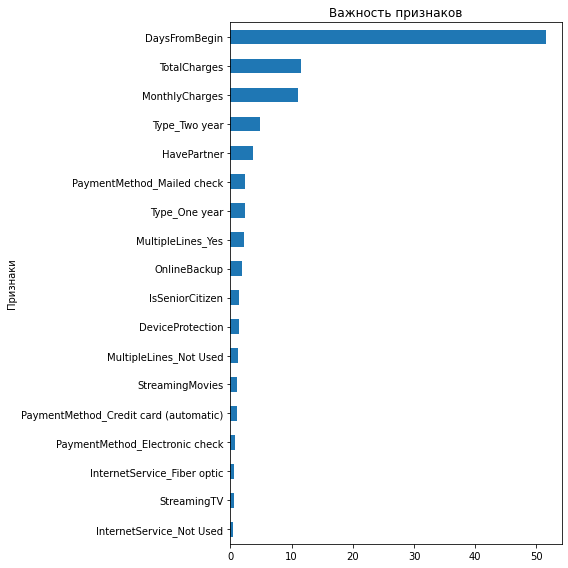

In [74]:
feat_imp = pd.Series(cb.get_feature_importance(Pool(test_features, label=test_target)),
                         test_features.columns)
feat_imp = feat_imp.sort_values()
fig, ax = plt.subplots(figsize=(8,8))
feat_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Признаки')
fig.tight_layout()

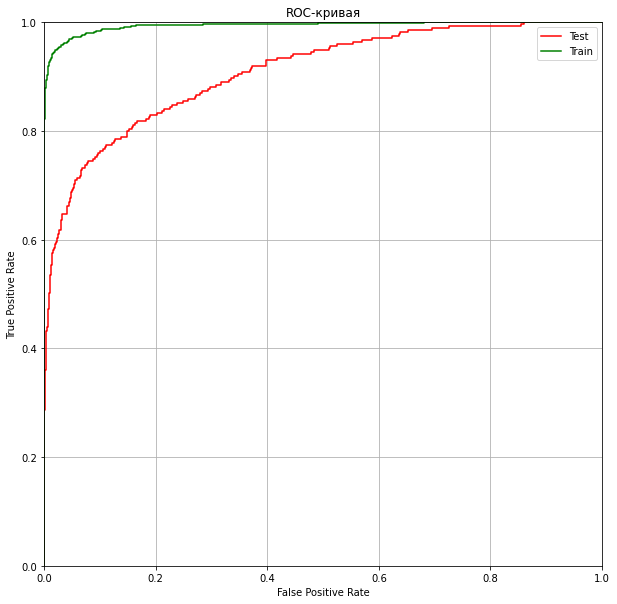

In [69]:
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds =roc_curve(test_target,cb.predict_proba(test_features)[:, 1])
plt.plot(fpr, tpr, linestyle='-', color='red')
fpr, tpr, thresholds =roc_curve(train_target,cb.predict_proba(train_features)[:, 1])
plt.plot(fpr, tpr, linestyle='-', color='green')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(['Test','Train'])
plt.show()

Модель CatBoostClassifier на тестовом наборе данных имеет метрику AUC_ROC 0.90, accuracy 0.92.

Ложно позитивное предсказание минимальное, что является хорошим показателем для задачи удержания клиента.

Наиболее важным для модели признаком является - количество дней которые клиент пользуется услугами компании (до даты отказа от услуг для ушедших клиентов и до даты выгрузки датасета для текущих). При предсказании оттока клиентов будет использована дата выгрузки датасета. Также важными для модели признаками являются суммарные и ежемесяцные затраты на услуги.

## Отчет

В проекте решена задача прогнозирования оттока клиентов оператора связи «Ниединогоразрыва.ком»

После проведения маркетингового исследования было выявлено учащение оттока клиентов к конкурентам. Принято решение сконцентрироваться на удержании текущего клиента путем предложения специальных условий, промокодов. Для определения потенциального уходящего клиента был выполнен данный проект.

*Цель проекта* : в течении 7 дней разработать модель прогнозирования оттока клиентов точностью AUC-ROC не менее 0.85.

Работы выполнены в соответствии с планом:

- **Предварительный анализ**

Данные о клиентах представленны в виде нескольких таблиц с ключем - уникальным ID пользователя. 

- **Предобработка**

Данные не содержат пропусков, но при объединении таблиц видим, что некоторые клиенты пользуются только одним видом услуг - интернетом или телефонией. Возникшие пропуски заполняем так, чтобы различать клиента, выбравшего не подключать услугу, и клиента, не пользующегося услугой интернета/телефонии, потому что само подключение отсутствует.

Преобразованы типы данных:

ID клиента - индекс.

Дата начала пользования услуг приведена к формату даты.

Данные о безналичном расчете, наличии супруга, наличии иждивенцев, поле клиента, пенсионном статусе и информации об использовании интернет-сервисов приведены к логическому типу, также для исследования добавлены признаки об использовании видов соединения.

Тип оплаты, способ оплаты, тип интернет-соединения и наличие возможности ведения параллельных разговоров приведены к категориальному типу.

Численные данные - месечная и общая сумма за услуги - без изменений.

Создан признак о количестве дней пользования услугами -  с даты начала до даты окончания/выгрузки данных.

Создан целевой признак на основе данных о дате окончания пользования услугами.

- **Исседовательский анализ**

Среднемесячная сумма за услуги у ушедших клиентов в среднем выше, чем у текущих.

Видно, что у компании много новых клиентов. Большая часть ушедших - клиенты, чьи расходы на услуги выше медианы, по пользователям с той же длительностью пользования услугами. Среди старых клиентов ушедших мало.

Портрет уходящего клиента:

Клиенты с супругом или имеющие пенсионный статус, пользуюшиеся более дорогостоящими услугами, такие как оптоволоконное соединение и MultipleLines, оплата которых производится автоматически раз в год или раз в два года, на 75% чаще остальных клиентов компании отказываются от услуг «Ниединогоразрыва.ком»

- **Подготовка признаков** 

Признаки отобраны на основе графика корреляции: данные о безналичном расчете, поле клиента, наличии иждивенцев, использовании услуг TechSupport и OnlineSecurity, а также созданные признаки об использовании видов соединения не показали достаточной для положительного влияния на модель корреляции с целевым признаком. 

Оставлены признаки: количество дней пользования услугами, среднемесячные и общие затраты на услуги, наличие пенсионного статуса, наличие супруга, дополнительные интернет-сервисы, тип оплаты, метод оплаты, тип интернет-соединения, тип телефонного соединения.

Данные разбиты на обучающую и тестовую выборки (75:25) с применением стратификации, поскольку в данных присутствует дисбаланс целевого признака.

Для кодировки категориальных признаков применен метод One-Hot Encoding, средствами библиотеки pandas.

- **Обучение модели**

Для решения задачи классификации клиентов выбраны модели: *CatBoostClassifier, RandomForestClassifier, LogisticRegression*.

Подбор параметров модели осуществлен с помощью инструмента библиотеки sklearn -  GridSearchCV (поиск лучших параметров в фиксированной сетке возможных значений на кросс-валидации).

Показатели метрики roc_auc на кросс-валидации, лучшие параметры моделей:

*CatBoostClassifier* 

roc_auc score: 0.92, параметры: 'depth': 5, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1

*RandomForestClassifier* 
roc_auc score: 0.83, параметры: 'max_depth': 8, 'n_estimators': 30

*LogisticRegression *
roc_auc score: 0.77, параметры: 'C': 10, 'max_iter': 1000

- **Проверка модели**

Модель *CatBoostClassifier* показзала лучший результат на кросс-валидации и выбрана в качестве итоговой модели.

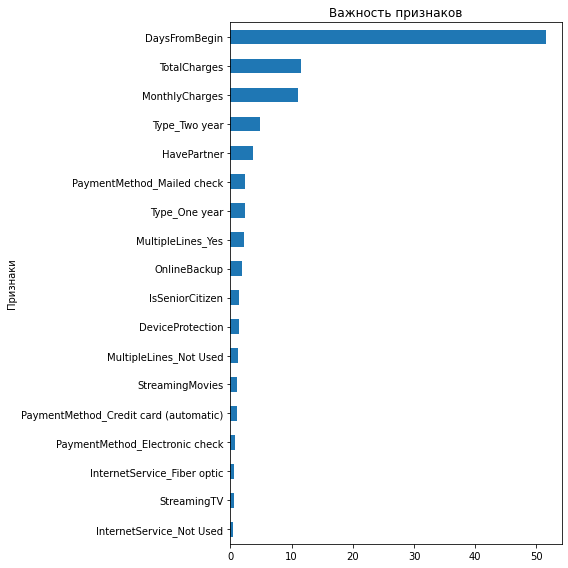

In [75]:
fig, ax = plt.subplots(figsize=(8,8))
feat_imp.plot.barh(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Признаки')
a = fig.tight_layout()

Наиболее важным для модели признаком является количество дней, которое клиент пользуется услугами компании (до даты отказа от услуг для ушедших клиентов и до даты выгрузки датасета для текущих). При предсказании оттока клиентов будет использована дата выгрузки датасета. Также важными для модели признаками являются суммарные и ежемесячные затраты на услуги.

Метрика *roc_auc* итоговой модели на тестовом наборе данных: 0.90

Метрика *accuracy* итоговой модели на тестовом наборе данных: 0.92

Достигнута цель проекта: метрика AUC-ROC итоговой модели прогнозирования оттока клиента превышает требуемую точность AUC-ROC - не менее 0.85

Основые затруднения в написании проекта связаны с предобработкой и подготовкой признаков, которые, по моему мнению, и являются ключевыми шагами в решении задачи.

**Рекоменданции**

В ходе исследовательского анализа данных о клиентах оператора связи «Ниединогоразрыва.ком» выявлены следующие закономерности, связанные с оттоком клиентов:

- Среди тех, кто пользуется услугами дольше всего, очень мало ушедших клиентов. Наблюдается группа текущих пользователей с минимальными возможными затратами.

С целью более рационального распределения бюждета на удержание клиентов рекомендуется сосредоточиться, в первую очередь, на новых клиентах, пользующихся дополнительными услугами компании.

- Клиенты с супругом откаываются от услуг значително чаще, чем клиенты без супруга. Также чаще отказываются от услуг клиенты с пенсионным статусом и пользователи дополнительных интернет-услуг.

Для таких клиентов можно разработать специальные предложения. Процент уходящих клиентов в этих категориях значительно выше среднего. 

- При оплате раз в год и раз в два года клиенты уходят чаще, чем при помесячной оплате. Процент ушедших клиентов, использующих автоматическую оплату, превышает средний процент ушедших клиентов.

Автоматическое списание средств на оплату услуг негативно сказывается на удержании клиента. А разовые автоматические списания одно/двух-годовой суммы, могут быть причиной отказа от услуг.

Рекомендуется выполнить проверку на наличие уведомлений об оплате клиентам с автоматическим видом списания денежных средств. При наличии таких уведомлений рассмотреть возможность дополнительного оповещения клиента. Также рекомендуется пересмотреть типы оплаты.